In [1]:
%%HTML
# Basic styling for the notebook in vscode
<style>
    body {
        --vscode-font-family: "avenir";
        --vscode-font-weight: 500;
    }
</style>    

In [2]:
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt

module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import add_growth_score_based_on_main_features, add_days_since_last_release_col, add_repo_age_days_col, convert_topics_to_embeddings, indexify_release_dates, add_lag_features_based_on_target, forecast_growth

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

/opt/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
df = pd.read_csv('../data/github_data.csv')
df.head()

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,num_releases,num_stars,num_forks,num_open_issues,num_pull_requests,release_tag,release_date
0,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,https://github.com/Significant-Gravitas/AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16T09:21:07Z,2024-09-14T17:57:57Z,21,166492,44062,144,4229,autogpt-v0.5.1,2024-04-26T20:15:57Z
1,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,https://github.com/Significant-Gravitas/AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16T09:21:07Z,2024-09-14T17:57:57Z,21,166492,44062,144,4229,autogpt-v0.5.0,2023-12-14T15:17:16Z
2,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,https://github.com/Significant-Gravitas/AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16T09:21:07Z,2024-09-14T17:57:57Z,21,166492,44062,144,4229,agbenchmark-v0.0.10,2023-09-17T00:02:08Z
3,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,https://github.com/Significant-Gravitas/AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16T09:21:07Z,2024-09-14T17:57:57Z,21,166492,44062,144,4229,v0.4.7,2023-08-11T17:55:06Z
4,Significant-Gravitas,AutoGPT,AutoGPT is the vision of accessible AI for eve...,https://github.com/Significant-Gravitas/AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16T09:21:07Z,2024-09-14T17:57:57Z,21,166492,44062,144,4229,v0.4.6,2023-07-28T12:42:29Z


In [4]:
# Functions Definitions
    
def provideMissingDesc(repo_name, description):
    df.loc[df['repo_name'] == repo_name, 'description'] = description

## Data Cleanup

In [5]:
print(df.shape)
print(df.describe())


(10853, 14)
       num_releases      num_stars     num_forks  num_open_issues  \
count  10853.000000   10853.000000  10853.000000     10853.000000   
mean      24.294389    8548.470100   1225.364323       204.723487   
std        8.919266   13745.213302   2814.309386       504.489635   
min        0.000000    1191.000000      5.000000         0.000000   
25%       21.000000    1974.000000    235.000000        26.000000   
50%       30.000000    3827.000000    448.000000        74.000000   
75%       30.000000    9274.000000   1142.000000       187.000000   
max       30.000000  166492.000000  44062.000000      4755.000000   

       num_pull_requests  
count       10853.000000  
mean         1726.498940  
std          5253.444412  
min             0.000000  
25%            87.000000  
50%           315.000000  
75%          1215.000000  
max         47680.000000  


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10853 entries, 0 to 10852
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   org_name           10853 non-null  object
 1   repo_name          10853 non-null  object
 2   description        10817 non-null  object
 3   repo_url           10853 non-null  object
 4   topics             9845 non-null   object
 5   creation_date      10853 non-null  object
 6   update_date        10853 non-null  object
 7   num_releases       10853 non-null  int64 
 8   num_stars          10853 non-null  int64 
 9   num_forks          10853 non-null  int64 
 10  num_open_issues    10853 non-null  int64 
 11  num_pull_requests  10853 non-null  int64 
 12  release_tag        10435 non-null  object
 13  release_date       10435 non-null  object
dtypes: int64(5), object(9)
memory usage: 1.2+ MB
None


There seem to be some missing values in the description and the release date / release tag columns. I will research the related repositories to try to extract some descriptions to fill up the gap.
Also I'll convert the `creation_date` and the `update_date` to datetime format.

In [7]:
df[df['description'].isna()].head(10)

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,num_releases,num_stars,num_forks,num_open_issues,num_pull_requests,release_tag,release_date
4107,bilibili,ailab,NaN,https://github.com/bilibili/ailab,NaN,2021-05-07T03:03:28Z,2024-09-14T07:56:49Z,3,5593,549,74,13,Real-CUGAN-add-low-memory-mode,2022-02-20T16:17:25Z
4108,bilibili,ailab,NaN,https://github.com/bilibili/ailab,NaN,2021-05-07T03:03:28Z,2024-09-14T07:56:49Z,3,5593,549,74,13,Real-CUGAN-add-faster-low-memory-mode,2022-02-27T06:55:52Z
4109,bilibili,ailab,NaN,https://github.com/bilibili/ailab,NaN,2021-05-07T03:03:28Z,2024-09-14T07:56:49Z,3,5593,549,74,13,Real-CUGAN,2022-02-02T03:45:25Z
6177,krishnaik06,Roadmap-To-Learn-Generative-AI-In-2024,NaN,https://github.com/krishnaik06/Roadmap-To-Lear...,NaN,2023-12-11T11:43:22Z,2024-09-14T06:59:42Z,0,3049,1332,6,5,NaN,NaN
6822,crewAIInc,crewAI-examples,NaN,https://github.com/crewAIInc/crewAI-examples,NaN,2023-12-19T11:46:48Z,2024-09-14T13:22:24Z,0,2613,970,37,79,NaN,NaN
10222,yuvalsuede,ai-component-generator,NaN,https://github.com/yuvalsuede/ai-component-gen...,NaN,2023-03-04T01:12:52Z,2024-09-14T09:22:35Z,0,1340,124,10,18,NaN,NaN
10569,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-13T13:44:30Z,30,1234,129,255,499,11.0.0-SNAPSHOT.20240424015024,2024-04-24T01:56:03Z
10570,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-13T13:44:30Z,30,1234,129,255,499,11.0.0-SNAPSHOT.20230217142243,2023-02-17T14:30:18Z
10571,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-13T13:44:30Z,30,1234,129,255,499,11.0.0-SNAPSHOT.20230217141800,2023-02-17T14:27:35Z
10572,airsonic-advanced,airsonic-advanced,NaN,https://github.com/airsonic-advanced/airsonic-...,NaN,2019-11-12T21:35:06Z,2024-09-13T13:44:30Z,30,1234,129,255,499,11.0.0-SNAPSHOT.20230217141758,2023-02-17T14:25:37Z


In [8]:
# Fix the missing description by copying description form the repo's README file

provideMissingDesc("ml-ferret", "An End-to-End MLLM that Accept Any-Form Referring and Ground Anything in Response.")
provideMissingDesc("ailab", "Real Cascade U-Nets for Anime Image Super Resolution")
provideMissingDesc("MTProxy", "Simple MT-Proto proxy")
provideMissingDesc("MLOps-Basics", "The goal of the series is to understand the basics of MLOps like model building, monitoring, configurations, testing, packaging, deployment, cicd, etc")
provideMissingDesc("gpt-llm-trainer", "The goal of this project is to explore an experimental new pipeline to train a high-performing task-specific model. We try to abstract away all the complexity, so it's as easy as possible to go from idea -> performant fully-trained model.")
provideMissingDesc("ml-mgie", "Guiding Instruction-based Image Editing via Multimodal Large Language Models")
provideMissingDesc("NLPIR", "NLPIR stores relevant files of the NLPIR big data semantic enhanced analysis platform")
provideMissingDesc("Roadmap-To-Learn-Generative-AI-In-2024", "Roadmap To Learn Generative AI In 2024")
provideMissingDesc("crewAI-examples", "crewAI is designed to facilitate the collaboration of role-playing AI agents. This is a collection of examples of different ways to use the crewAI framework to automate the processes")
provideMissingDesc("LLM-Agent-Survey", "A Survey on LLM-based Autonomous Agents")
provideMissingDesc("airsonic-advanced", "Airsonic-Advanced is a more modern implementation of the Airsonic fork with several key performance and feature enhancements. It adds and supersedes several features in Airsonic.")
provideMissingDesc("ai-component-generator", "This project generates almost any UI components with OpenAI's ChatGPT and allows you to copy the html code")

In [9]:
print(df['description'].isna().sum())

0


In [10]:
df[df['release_date'].isna()].head(10)

,org_name,repo_name,description,repo_url,topics,creation_date,update_date,num_releases,num_stars,num_forks,num_open_issues,num_pull_requests,release_tag,release_date
62,fighting41love,funNLP,中英文敏感词、语言检测、中外手机/电话归属地/运营商查询、名字推断性别、手机号抽取、身份证抽...,https://github.com/fighting41love/funNLP,NaN,2018-08-21T11:20:39Z,2024-09-14T17:34:05Z,0,67651,14402,156,26,NaN,NaN
63,microsoft,generative-ai-for-beginners,"18 Lessons, Get Started Building with Generati...",https://github.com/microsoft/generative-ai-for...,"ai, chatgpt, dall-e, generativeai, gpt, azure,...",2023-06-19T16:28:59Z,2024-09-14T17:21:42Z,0,61794,31454,30,368,NaN,NaN
499,microsoft,AI-For-Beginners,"12 Weeks, 24 Lessons, AI for All!",https://github.com/microsoft/AI-For-Beginners,"deep-learning, artificial-intelligence, machin...",2021-03-03T16:27:36Z,2024-09-14T15:35:59Z,0,34034,5660,55,251,NaN,NaN
500,google-research,google-research,Google Research,https://github.com/google-research/google-rese...,"machine-learning, ai, research",2018-10-04T18:42:48Z,2024-09-14T16:11:24Z,0,33806,7831,1464,867,NaN,NaN
501,xitu,gold-miner,🥇掘金翻译计划，可能是世界最大最好的英译中技术社区，最懂读者和译者的翻译平台：,https://github.com/xitu/gold-miner,"android, translation, ios, frontend, react, tu...",2015-11-04T03:29:13Z,2024-09-13T20:37:14Z,0,33656,5022,7,3846,NaN,NaN
562,GitHubDaily,GitHubDaily,坚持分享 GitHub 上高质量、有趣实用的开源技术教程、开发者工具、编程网站、技术资讯。A...,https://github.com/GitHubDaily/GitHubDaily,"github, open-source, ai, java, python, web, ja...",2018-12-30T13:56:58Z,2024-09-14T15:56:27Z,0,31842,3509,279,19,NaN,NaN
738,Pythagora-io,gpt-pilot,The first real AI developer,https://github.com/Pythagora-io/gpt-pilot,"ai, codegen, developer-tools, gpt-4, coding-as...",2023-08-16T11:56:07Z,2024-09-14T17:59:03Z,0,29636,2948,221,484,NaN,NaN
769,AMAI-GmbH,AI-Expert-Roadmap,Roadmap to becoming an Artificial Intelligence...,https://github.com/AMAI-GmbH/AI-Expert-Roadmap,"deep-learning, artificial-intelligence, roadma...",2020-10-24T21:49:40Z,2024-09-14T12:32:02Z,0,28992,2456,20,17,NaN,NaN
803,mckaywrigley,chatbot-ui,AI chat for every model.,https://github.com/mckaywrigley/chatbot-ui,NaN,2023-03-11T14:53:14Z,2024-09-14T16:03:55Z,0,28307,7861,175,711,NaN,NaN
900,svc-develop-team,so-vits-svc,SoftVC VITS Singing Voice Conversion,https://github.com/svc-develop-team/so-vits-svc,"ai, audio-analysis, generative-adversarial-net...",2023-03-10T09:31:09Z,2024-09-14T17:27:40Z,0,25338,4753,28,186,NaN,NaN


Since the release_date feature is a very relevant feature for our model we'll drop rows that don't have a release_date.

In [11]:
df = df.dropna(subset=['release_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10435 entries, 0 to 10851
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   org_name           10435 non-null  object
 1   repo_name          10435 non-null  object
 2   description        10435 non-null  object
 3   repo_url           10435 non-null  object
 4   topics             9552 non-null   object
 5   creation_date      10435 non-null  object
 6   update_date        10435 non-null  object
 7   num_releases       10435 non-null  int64 
 8   num_stars          10435 non-null  int64 
 9   num_forks          10435 non-null  int64 
 10  num_open_issues    10435 non-null  int64 
 11  num_pull_requests  10435 non-null  int64 
 12  release_tag        10435 non-null  object
 13  release_date       10435 non-null  object
dtypes: int64(5), object(9)
memory usage: 1.2+ MB


In [12]:
num_na_values_per_repo = df.groupby('repo_name')['topics'].apply(lambda x: x.isna().sum())
num_na_values_per_repo = num_na_values_per_repo[num_na_values_per_repo > 0]
print(f"Number of NaN values in 'topics' column: {num_na_values_per_repo.head(50)}")

Number of NaN values in 'topics' column: repo_name
AI                              2
AI-Writer                       8
AI-on-the-edge-device          30
AI0x0.com                      30
AITemplate                      2
AiNiee                         30
AirGuard                       18
AntiFraudChatBot                1
Arcade-Learning-Environment    15
Auto-Synced-Translated-Dubs    24
DevOpsGPT                       2
DouZero_For_HappyDouDiZhu       2
FlagAI                         30
GameAISDK                       1
KMS_VL_ALL_AIO                 21
KoboldAI-Client                 5
Linly-Talker                    1
MoneyPrinterPlus               11
Open-Sora-Plan                  3
ParlAI                         23
PhoenixGo                       5
PraisonAI                      30
RealChar                       30
SalesGPT                       11
SecureAI-Tools                  5
Vitis-AI                       13
agent-zero                     10
ai-edu                         

In [13]:
# Save a backup copy of the repo and topic with NaN value so that later I can verify the populated values
# df[df['topics'].isna()][['repo_name', 'topics']].drop_duplicates(subset=['repo_name']).reset_index(drop=True)

na_unique_indices = df[df['topics'].isna()].drop_duplicates(subset=['repo_name']).index

na_unique_indices

Index([  901,  1974,  2275,  2429,  2834,  3085,  3220,  3232,  3265,  3302,
        3349,  3603,  3830,  4012,  4036,  4107,  4331,  4595,  4688,  4703,
        4816,  4866,  5201,  5346,  5435,  5622,  5833,  5938,  5961,  5990,
        6164,  6167,  6213,  6255,  6285,  6359,  6370,  6375,  6911,  6982,
        7015,  7034,  7134,  7570,  7572,  7734,  7758,  7762,  7847,  7917,
        7978,  8097,  8177,  8180,  8228,  8346,  8714,  8878,  9199,  9358,
        9397,  9438,  9449,  9474,  9490,  9587,  9750,  9812,  9887,  9923,
       10365, 10569, 10822],
      dtype='int64')

In [14]:
len(df.topics.unique())

510

In [15]:
# Populate the missing topics with predefined values using the transformer library with facebook/bart-large-mnli model

from transformers import pipeline # pip install transformers

# NLP - Natural Language Processing
# NLG - Natural Language Generation
# MT - Machine Translation
# ML - Machine Learning
# MML - Multi-Modal Learning
# RL - Reinforcement Learning
# ASR - Automatic Speech Recognition
# TTS - Text-to-Speech
# RPA - Robotic Process Automation
# IR - Information Retrieval
# DL - Deep Learning
# OCR - Optical Character Recognition


classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define candidate topics
candidate_topics = ["NLP", "NLG", "MT", "ML", "MML", "LLM", "RL", "ASR", "TTS", "RPA", "IR", "DL", "OCR", "python", "gpt"]

# Drop duplicates to get unique 'repo_name' and 'topics' combinations
unique_topics = df.drop_duplicates(subset=['repo_name', 'topics']).reset_index(drop=True)

# Apply classification only to rows where 'topics' is NaN
def classify_topic(row):
    if pd.isna(row['topics']):
        description = row['description'] if pd.notna(row['description']) else "No description available"
        candidate_topics_lower = [topic.lower() for topic in candidate_topics]
        return classifier(description, candidate_topics_lower)['labels'][0]
    else:
        return row['topics']

unique_topics['topics'] = unique_topics.apply(classify_topic, axis=1) # type: ignore

# Merge the updated topics back into the original DataFrame
df = pd.merge(df, unique_topics[['repo_name', 'topics']], 
            on=['repo_name'], how='left', suffixes=('', '_new'))

# Update the 'topics' column in the original DataFrame
df['topics'] = df['topics_new'].combine_first(df['topics'])

# Drop the helper column after merging
df.drop(columns=['topics_new'], inplace=True)

# Estimated 2m 11.4s

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [16]:
# Verify the populated NaN values
print("\nRows with NaN 'topics' before filling (unique per repo_name):")
print(df.loc[na_unique_indices[:-2]]['topics'].head(50))


Rows with NaN 'topics' before filling (unique per repo_name):
901     ml, artificial-intelligence, hacktoberfest, my...
1974    data-science, machine-learning, reproducibilit...
2275    automation, data-engineering, data-ops, data-v...
2429                                                  asr
2834                                                  asr
3085    machine-learning, artificial-intelligence, dat...
3220    react-native, camera, library, javascript, rea...
3232    react-native, camera, library, javascript, rea...
3265    go, golang, low-code, framework, self-hosted, ...
3302    model-serving, mlops, llmops, generative-ai, l...
3349    ai, lancedb, llama, llamacpp, local-first, mar...
3603        generative-ai, krita-plugin, stable-diffusion
3830    generative-ai, generative-ui, nextjs, react, t...
4012                                                  asr
4036    vespa, search-engine, big-data, ai, serving, s...
4107                      rpa, ai, opencv, tesseract, nlp
4331     

In [17]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10525 entries, 0 to 10524
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   org_name           10525 non-null  object
 1   repo_name          10525 non-null  object
 2   description        10525 non-null  object
 3   repo_url           10525 non-null  object
 4   topics             10525 non-null  object
 5   creation_date      10525 non-null  object
 6   update_date        10525 non-null  object
 7   num_releases       10525 non-null  int64 
 8   num_stars          10525 non-null  int64 
 9   num_forks          10525 non-null  int64 
 10  num_open_issues    10525 non-null  int64 
 11  num_pull_requests  10525 non-null  int64 
 12  release_tag        10525 non-null  object
 13  release_date       10525 non-null  object
dtypes: int64(5), object(9)
memory usage: 1.1+ MB
None


In [18]:
df['creation_date'] = pd.to_datetime(df['creation_date'], utc=True)
df['update_date'] = pd.to_datetime(df['update_date'], utc=True)
df['release_date'] = pd.to_datetime(df['release_date'], utc=True)

In [19]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10525 entries, 0 to 10524
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   org_name           10525 non-null  object             
 1   repo_name          10525 non-null  object             
 2   description        10525 non-null  object             
 3   repo_url           10525 non-null  object             
 4   topics             10525 non-null  object             
 5   creation_date      10525 non-null  datetime64[ns, UTC]
 6   update_date        10525 non-null  datetime64[ns, UTC]
 7   num_releases       10525 non-null  int64              
 8   num_stars          10525 non-null  int64              
 9   num_forks          10525 non-null  int64              
 10  num_open_issues    10525 non-null  int64              
 11  num_pull_requests  10525 non-null  int64              
 12  release_tag        10525 non-null  object     

## EDA

In [20]:
# How many unique orgs are there?

print(f"{len(df.org_name.unique())} unique orgs")
print("-"*100)
print(df.org_name.unique()[:20],'...')

520 unique orgs
----------------------------------------------------------------------------------------------------
['Significant-Gravitas' 'AUTOMATIC1111' 'supabase' 'AppFlowy-IO' 'lencx'
 'gpt-engineer-org' 'langgenius' 'geekan' 'lobehub' 'apachecn'
 'open-webui' 'Kong' 'hpcaitech' 'LAION-AI' 'pingcap' 'ClickHouse'
 'apache' 'QuivrHQ' 'hacksider' 'babysor'] ...


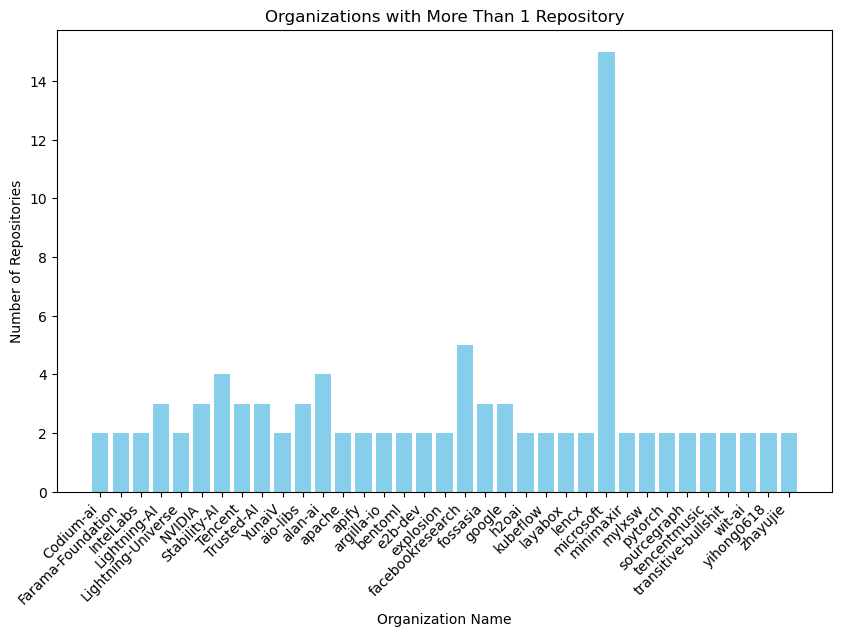

In [21]:
# Are there orgs that have multiple repos?

org_repo_count = df.groupby('org_name')['repo_name'].nunique().reset_index()
org_repo_count.columns = ['org_name', 'num_repos']
orgs_with_multiple_repos = org_repo_count[org_repo_count['num_repos'] > 1]

# Plot orgs that have more than one repos
plt.figure(figsize=(10, 6)) 
plt.bar(orgs_with_multiple_repos['org_name'], orgs_with_multiple_repos['num_repos'], color='skyblue')
plt.xlabel('Organization Name')
plt.ylabel('Number of Repositories')
plt.title('Organizations with More Than 1 Repository')
plt.xticks(rotation=45, ha='right')
plt.show()

In [22]:
# Which repos have the highest number of open issues?

open_pull_requests_per_repo = df.groupby(['creation_date', 'update_date', 'org_name', 'repo_name', 'num_pull_requests'])['num_open_issues'].sum().reset_index()
open_pull_requests_per_repo_sorted = open_pull_requests_per_repo.sort_values(by='num_open_issues', ascending=False)
open_pull_requests_per_repo_sorted = open_pull_requests_per_repo_sorted.reset_index(drop=True)

open_pull_requests_per_repo_sorted.head(20)

,creation_date,update_date,org_name,repo_name,num_pull_requests,num_open_issues
0,2015-08-24 07:27:28+00:00,2024-09-14 10:30:25+00:00,sourcegraph,sourcegraph-public-snapshot,42292,142650
1,2015-09-06 04:01:52+00:00,2024-09-14 16:12:20+00:00,pingcap,tidb,37043,136440
2,2016-10-25 19:38:30+00:00,2024-09-14 17:48:46+00:00,ray-project,ray,28955,120120
3,2016-06-02 08:28:18+00:00,2024-09-14 16:08:57+00:00,ClickHouse,ClickHouse,47680,118620
4,2020-07-27 23:55:54+00:00,2024-09-14 15:16:44+00:00,airbytehq,airbyte,27060,59790
5,2022-08-22 14:05:26+00:00,2024-09-14 17:27:42+00:00,AUTOMATIC1111,stable-diffusion-webui,3100,59228
6,2018-06-05 16:05:58+00:00,2024-09-14 09:56:46+00:00,mlflow,mlflow,8961,47580
7,2012-04-27 13:18:34+00:00,2024-09-14 17:06:28+00:00,magefree,mage,5171,44610
8,2022-12-07 09:43:02+00:00,2024-09-14 13:58:53+00:00,lencx,ChatGPT,166,43440
9,2015-04-13 18:04:58+00:00,2024-09-14 17:20:53+00:00,apache,airflow,28083,33270


In [23]:
# How many unique topics are there

print("Number of unique labels:", len(df.topics))
print("-"*100)
print("Unique labels:", list(df.topics)[:20])


Number of unique labels: 10525
----------------------------------------------------------------------------------------------------
Unique labels: ['ai, gpt-4, openai, python, artificial-intelligence, autonomous-agents', 'ai, gpt-4, openai, python, artificial-intelligence, autonomous-agents', 'ai, gpt-4, openai, python, artificial-intelligence, autonomous-agents', 'ai, gpt-4, openai, python, artificial-intelligence, autonomous-agents', 'ai, gpt-4, openai, python, artificial-intelligence, autonomous-agents', 'ai, gpt-4, openai, python, artificial-intelligence, autonomous-agents', 'ai, gpt-4, openai, python, artificial-intelligence, autonomous-agents', 'ai, gpt-4, openai, python, artificial-intelligence, autonomous-agents', 'ai, gpt-4, openai, python, artificial-intelligence, autonomous-agents', 'ai, gpt-4, openai, python, artificial-intelligence, autonomous-agents', 'ai, gpt-4, openai, python, artificial-intelligence, autonomous-agents', 'ai, gpt-4, openai, python, artificial-intelligen

Top Ten Recurrent Topics:
topics_split
ai                         5394
llm                        2345
python                     2315
machine-learning           2201
openai                     1925
chatgpt                    1889
deep-learning              1348
artificial-intelligence    1252
gpt                        1093
gpt-4                      1058
pytorch                     914
data-science                819
rag                         760
chatbot                     712
ml                          648
llmops                      646
tensorflow                  635
hacktoberfest               623
generative-ai               609
mlops                       590
Name: count, dtype: int64


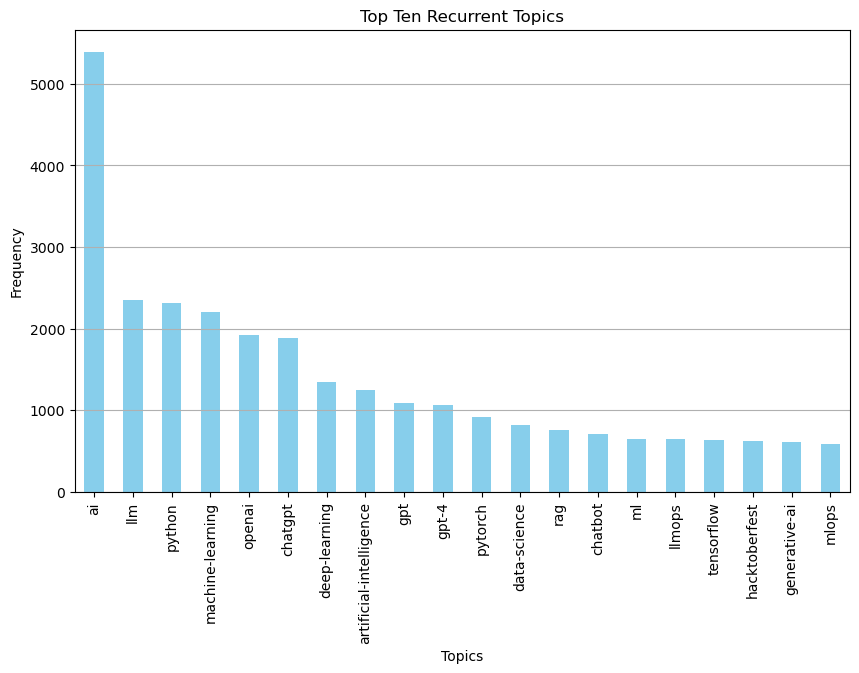

In [24]:
# What are the most recurrent topics 

topics_count_df = df.copy()

# Split the topics column by commas
topics_count_df['topics_split'] = topics_count_df['topics'].str.split(', ')

# Explode the list of topics into individual rows
df_exploded = topics_count_df.explode('topics_split')

# Count the frequency of each topic
topic_counts = df_exploded['topics_split'].value_counts()

# Get the top ten recurrent topics
top_topics = topic_counts.head(20)

# Display the top ten topics
print("Top Ten Recurrent Topics:")
print(top_topics)

# Visualize the top ten topics
plt.figure(figsize=(10, 6))
top_topics.plot(kind='bar', color='skyblue')
plt.title('Top Ten Recurrent Topics')
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

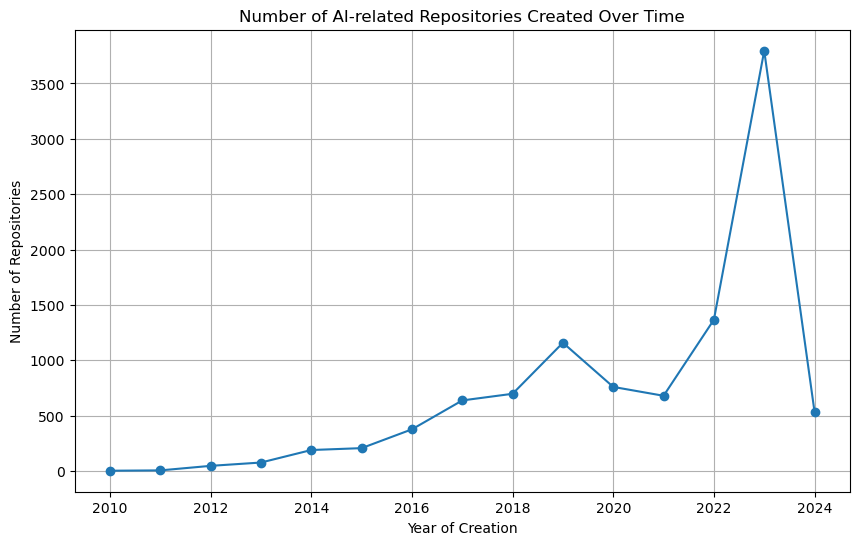

In [25]:
# Visualizing the progression of AI-related repos creation
df_creation = df.copy()
df_creation['creation_date'] = pd.to_datetime(df['creation_date'])

# Sort the DataFrame by 'creation_date' in ascending order
df_sorted = df_creation.sort_values(by='creation_date')

# Group by year see a trend over time
df_sorted['creation_year'] = df_sorted['creation_date'].dt.year
df_grouped = df_sorted.groupby('creation_year').size().reset_index(name='repo_count')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['creation_year'], df_grouped['repo_count'], marker='o')
plt.title('Number of AI-related Repositories Created Over Time')
plt.xlabel('Year of Creation')
plt.ylabel('Number of Repositories')
plt.grid(True)
plt.show()

                     count  mean  std   min   25%   50%   75%   max
repo_name                                                          
AElf                  30.0  30.0  0.0  30.0  30.0  30.0  30.0  30.0
AGiXT                 30.0  30.0  0.0  30.0  30.0  30.0  30.0  30.0
AI                     2.0   2.0  0.0   2.0   2.0   2.0   2.0   2.0
AI-Blocks             11.0  11.0  0.0  11.0  11.0  11.0  11.0  11.0
AI-Lossless-Zoomer     2.0   2.0  0.0   2.0   2.0   2.0   2.0   2.0
...                    ...   ...  ...   ...   ...   ...   ...   ...
yomo                  30.0  30.0  0.0  30.0  30.0  30.0  30.0  30.0
yudao-cloud           14.0  14.0  0.0  14.0  14.0  14.0  14.0  14.0
yudao-ui-admin-vue3   11.0  11.0  0.0  11.0  11.0  11.0  11.0  11.0
zenml                 30.0  30.0  0.0  30.0  30.0  30.0  30.0  30.0
zep                   30.0  30.0  0.0  30.0  30.0  30.0  30.0  30.0

[578 rows x 8 columns]


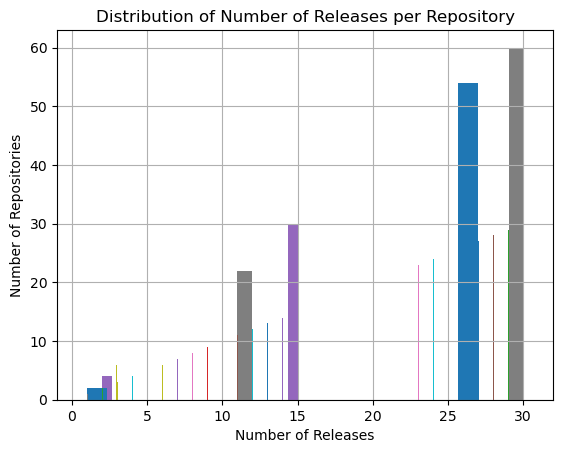

In [26]:
# How many releases are there per repo?

release_counts = df.groupby('repo_name')['num_releases']
print(release_counts.describe()) 
release_counts.hist(bins=20)
plt.xlabel('Number of Releases')
plt.ylabel('Number of Repositories')
plt.title('Distribution of Number of Releases per Repository')
plt.show()

## Feature Engineering & Per-processing

In [27]:
df_main = df.copy()

In [28]:
columns_to_drop = ['description', 'release_tag', 'repo_url', 'update_date']
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
if columns_to_drop:
    df_main.drop(columns=columns_to_drop, inplace=True)

I want to create a new `growth_score` dependent variable which will be based on `num_stars` + `num_forks` + `num_pull_requests`
but first I need to scale those values because they are very different from each other.

In [29]:
df_main= add_growth_score_based_on_main_features(df_main)

df_main.head()

,org_name,repo_name,topics,creation_date,num_releases,num_stars,num_forks,num_open_issues,num_pull_requests,release_date,growth_score
0,Significant-Gravitas,AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16 09:21:07+00:00,21,166492,44062,144,4229,2024-04-26 20:15:57+00:00,2.778351
1,Significant-Gravitas,AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16 09:21:07+00:00,21,166492,44062,144,4229,2023-12-14 15:17:16+00:00,2.778351
2,Significant-Gravitas,AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16 09:21:07+00:00,21,166492,44062,144,4229,2023-09-17 00:02:08+00:00,2.778351
3,Significant-Gravitas,AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16 09:21:07+00:00,21,166492,44062,144,4229,2023-08-11 17:55:06+00:00,2.778351
4,Significant-Gravitas,AutoGPT,"ai, gpt-4, openai, python, artificial-intellig...",2023-03-16 09:21:07+00:00,21,166492,44062,144,4229,2023-07-28 12:42:29+00:00,2.778351


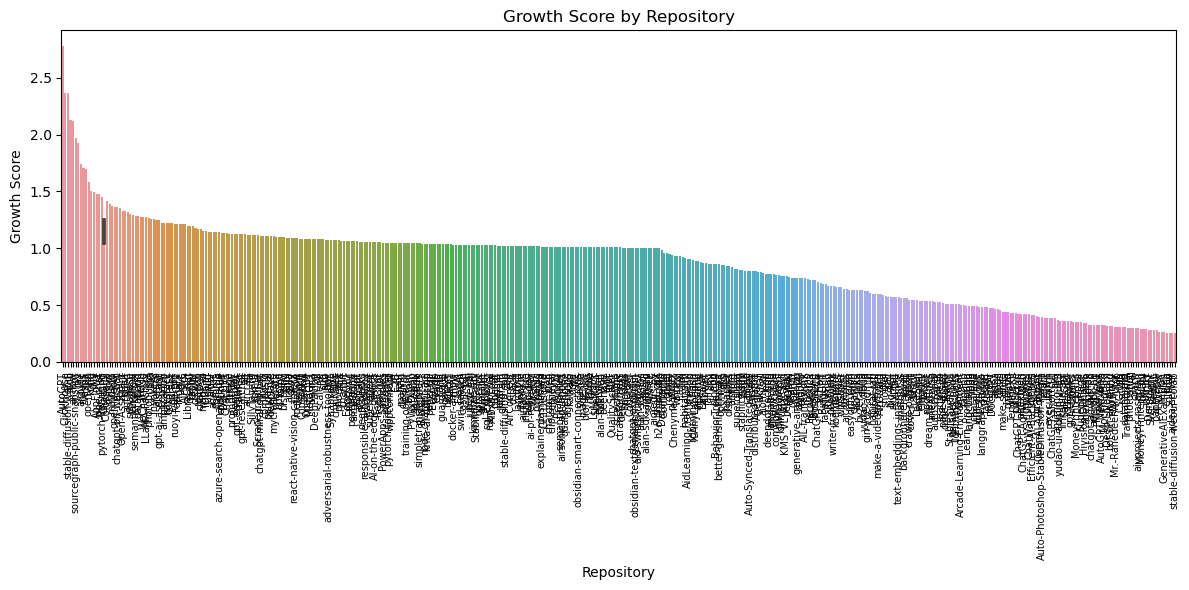

In [30]:
import seaborn as sns


df_filtered = df_main[df_main['growth_score'] > 0.25]

# Set the figure size
plt.figure(figsize=(12, 6))

# Bar plot showing growth_score for each repository
sns.barplot(x='repo_name', y='growth_score', data=df_filtered.sort_values(by='growth_score', ascending=False))

# Rotate x-axis labels for readability
plt.xticks(rotation=90, size=7)

# Add labels and title
plt.xlabel('Repository')
plt.ylabel('Growth Score')
plt.title('Growth Score by Repository')

# Show the plot
plt.tight_layout()
plt.show()

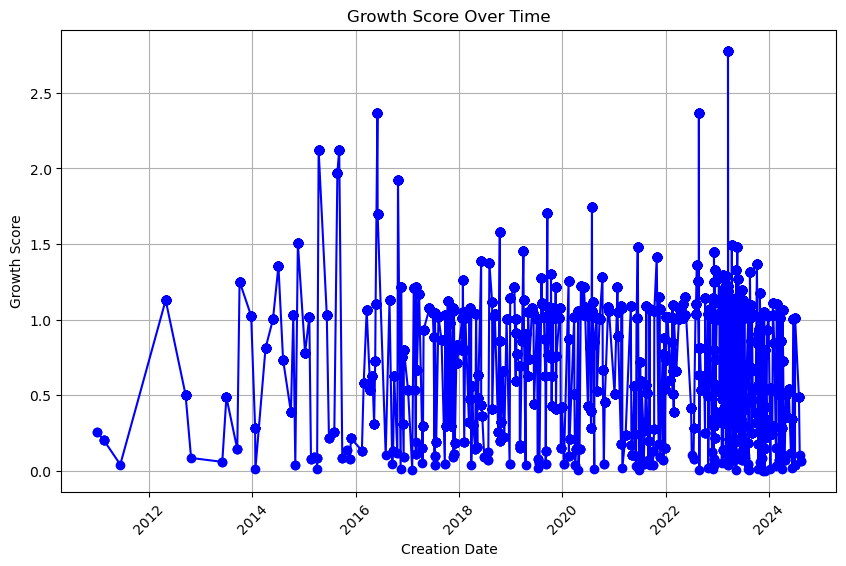

In [31]:
# Plot the growth score

# Sort the DataFrame by creation date to plot correctly
df_main = df_main.sort_values(by='creation_date')

# Plot growth_score over time
plt.figure(figsize=(10, 6))
plt.plot(df_main['creation_date'], df_main['growth_score'], marker='o', linestyle='-', color='b')
plt.xlabel('Creation Date')
plt.ylabel('Growth Score')
plt.title('Growth Score Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

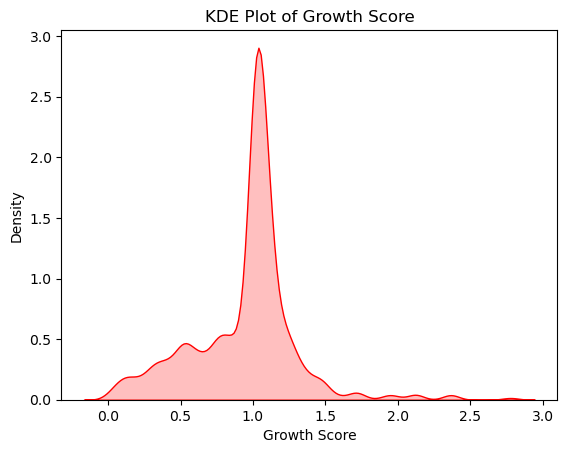

In [32]:
sns.kdeplot(df_main['growth_score'], shade=True, color="r")
plt.title('KDE Plot of Growth Score')
plt.xlabel('Growth Score')
plt.ylabel('Density')
plt.show()

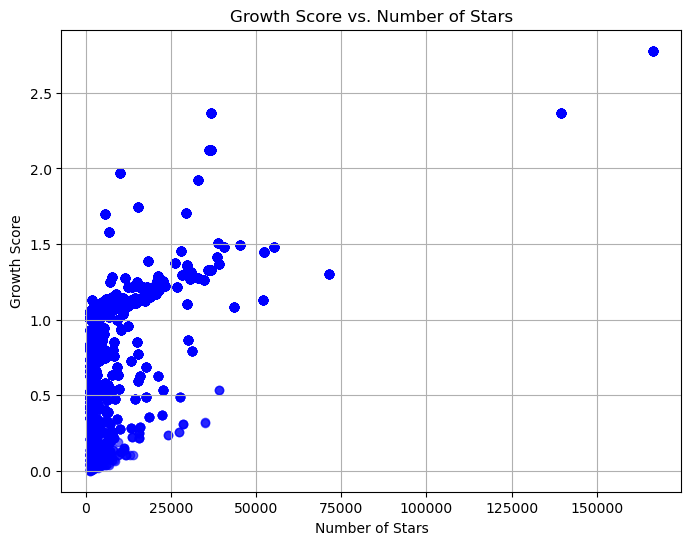

In [33]:
plt.figure(figsize=(8, 6))

# Scatter plot showing relationship between growth_score and num_stars
plt.scatter(df_main['num_stars'], df_main['growth_score'], alpha=0.6, color='b')

# Add labels and title
plt.xlabel('Number of Stars')
plt.ylabel('Growth Score')
plt.title('Growth Score vs. Number of Stars')

plt.grid(True)
plt.show()

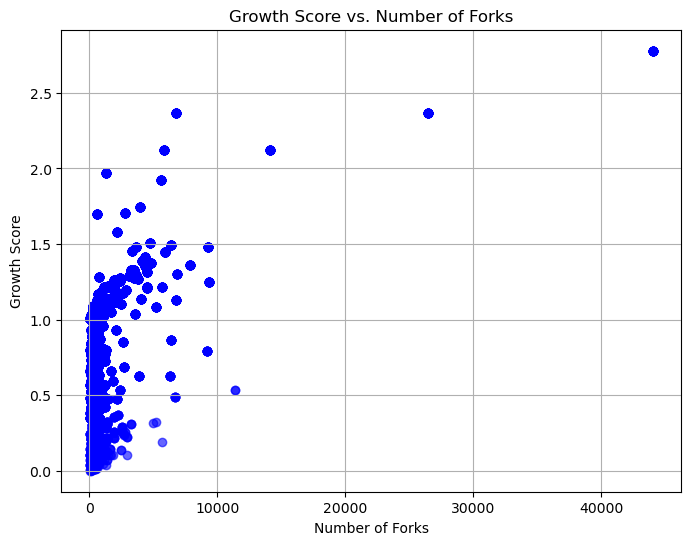

In [34]:
plt.figure(figsize=(8, 6))

# Scatter plot showing relationship between growth_score and num_stars
plt.scatter(df_main['num_forks'], df_main['growth_score'], alpha=0.6, color='b')

# Add labels and title
plt.xlabel('Number of Forks')
plt.ylabel('Growth Score')
plt.title('Growth Score vs. Number of Forks')

plt.grid(True)
plt.show()

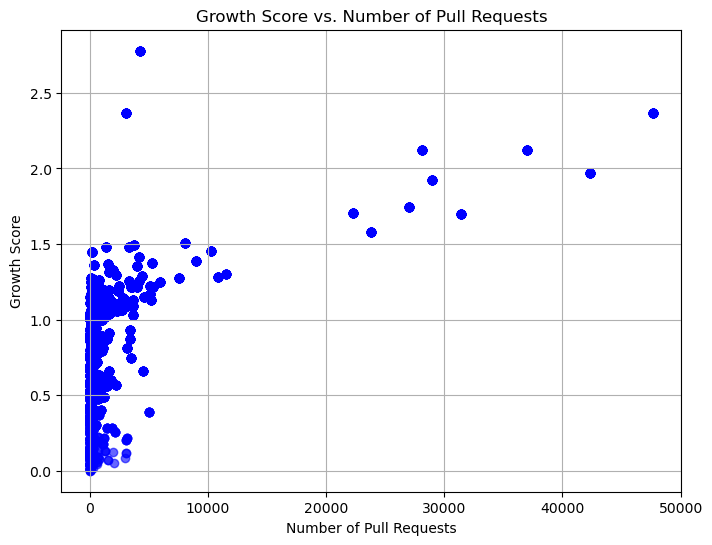

In [35]:
plt.figure(figsize=(8, 6))

# Scatter plot showing relationship between growth_score and num_stars
plt.scatter(df_main['num_pull_requests'], df_main['growth_score'], alpha=0.6, color='b')

# Add labels and title
plt.xlabel('Number of Pull Requests')
plt.ylabel('Growth Score')
plt.title('Growth Score vs. Number of Pull Requests')

plt.grid(True)
plt.show()

In [36]:
df_main = convert_topics_to_embeddings(df_main)
df_main.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charles.hanna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,org_name,repo_name,creation_date,num_releases,num_stars,num_forks,num_open_issues,num_pull_requests,release_date,growth_score,...,374,375,376,377,378,379,380,381,382,383
861,lutzroeder,netron,2010-12-26 12:53:43+00:00,2,27549,2743,23,223,2024-09-14 14:19:47+00:00,0.260569,...,0.005798,0.025285,-0.017150,-0.081812,-0.012775,0.029484,-0.005172,-0.001264,0.038663,0.020846
862,lutzroeder,netron,2010-12-26 12:53:43+00:00,2,27549,2743,23,223,2024-09-07 01:40:53+00:00,0.260569,...,0.005798,0.025285,-0.017150,-0.081812,-0.012775,0.029484,-0.005172,-0.001264,0.038663,0.020846
5880,apache,incubator-kie-optaplanner,2011-02-15 19:38:23+00:00,4,3311,943,21,3121,2023-08-17 21:03:36+00:00,0.202821,...,0.021370,0.033177,0.030128,-0.061588,0.039178,-0.016192,-0.000896,0.093104,0.021486,-0.017910
5879,apache,incubator-kie-optaplanner,2011-02-15 19:38:23+00:00,4,3311,943,21,3121,2023-08-17 21:10:54+00:00,0.202821,...,0.021370,0.033177,0.030128,-0.061588,0.039178,-0.016192,-0.000896,0.093104,0.021486,-0.017910
5878,apache,incubator-kie-optaplanner,2011-02-15 19:38:23+00:00,4,3311,943,21,3121,2023-09-06 06:12:48+00:00,0.202821,...,0.021370,0.033177,0.030128,-0.061588,0.039178,-0.016192,-0.000896,0.093104,0.021486,-0.017910


I want also to introduce 2 new features `repo_age_days` and `days_since_last_release`

In [37]:
df_main = add_repo_age_days_col(df_main)
df_main = add_days_since_last_release_col(df_main)

df_main.head()

,org_name,repo_name,num_releases,num_stars,num_forks,num_open_issues,num_pull_requests,release_date,growth_score,0,...,376,377,378,379,380,381,382,383,repo_age_days,days_since_last_release
861,lutzroeder,netron,2,27549,2743,23,223,2024-09-14 14:19:47+00:00,0.260569,-0.062094,...,-0.017150,-0.081812,-0.012775,0.029484,-0.005172,-0.001264,0.038663,0.020846,5017,6
862,lutzroeder,netron,2,27549,2743,23,223,2024-09-07 01:40:53+00:00,0.260569,-0.062094,...,-0.017150,-0.081812,-0.012775,0.029484,-0.005172,-0.001264,0.038663,0.020846,5017,14
5880,apache,incubator-kie-optaplanner,4,3311,943,21,3121,2023-08-17 21:03:36+00:00,0.202821,-0.006806,...,0.030128,-0.061588,0.039178,-0.016192,-0.000896,0.093104,0.021486,-0.017910,4966,400
5879,apache,incubator-kie-optaplanner,4,3311,943,21,3121,2023-08-17 21:10:54+00:00,0.202821,-0.006806,...,0.030128,-0.061588,0.039178,-0.016192,-0.000896,0.093104,0.021486,-0.017910,4966,400
5878,apache,incubator-kie-optaplanner,4,3311,943,21,3121,2023-09-06 06:12:48+00:00,0.202821,-0.006806,...,0.030128,-0.061588,0.039178,-0.016192,-0.000896,0.093104,0.021486,-0.017910,4966,380


<Axes: xlabel='growth_score'>

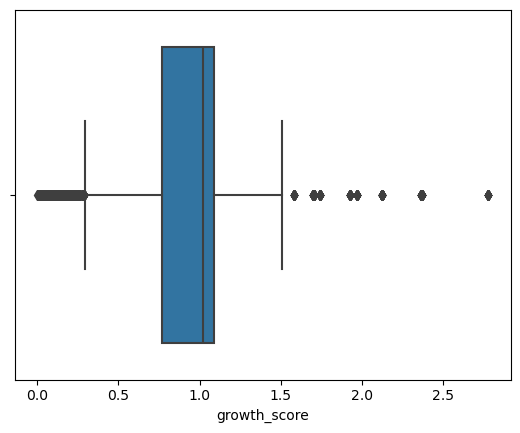

In [38]:
# Checking for outliers

sns.boxplot(x=df_main['growth_score'])

In [39]:
import numpy as np

def detect_outliers_z_score(df, column):
    threshold = 2.8
    mean = np.mean(df[column])
    std = np.std(df[column])
    z_scores = (df[column] - mean) / std
    return df[np.abs(z_scores) > threshold]

# Detect outliers in the 'growth_score' column
outliers = detect_outliers_z_score(df_main, 'growth_score')
print(outliers)

                 org_name repo_name  num_releases  num_stars  num_forks  \
462                apache   airflow            30      36295      14088   
461                apache   airflow            30      36295      14088   
460                apache   airflow            30      36295      14088   
459                apache   airflow            30      36295      14088   
458                apache   airflow            30      36295      14088   
..                    ...       ...           ...        ...        ...   
20   Significant-Gravitas   AutoGPT            21     166492      44062   
11   Significant-Gravitas   AutoGPT            21     166492      44062   
12   Significant-Gravitas   AutoGPT            21     166492      44062   
10   Significant-Gravitas   AutoGPT            21     166492      44062   
0    Significant-Gravitas   AutoGPT            21     166492      44062   

     num_open_issues  num_pull_requests              release_date  \
462             1109          

In [40]:
# Remove outliers detected by the IQR method
df_cleaned = df_main[~df_main.index.isin(outliers.index)]

<Axes: xlabel='growth_score'>

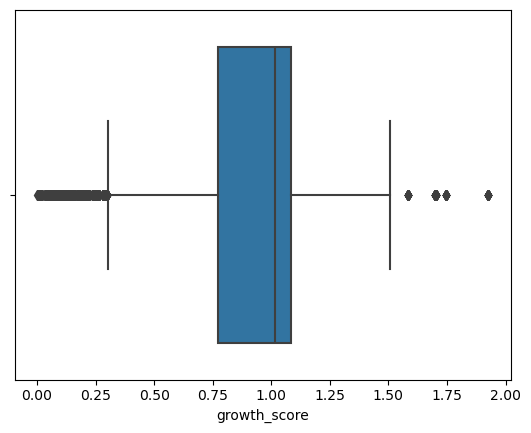

In [41]:
sns.boxplot(x=df_cleaned['growth_score'])

## Train & Testing

In [42]:
df_cleaned = indexify_release_dates(df_cleaned)
df_cleaned.head()

,org_name,repo_name,num_releases,num_stars,num_forks,num_open_issues,num_pull_requests,growth_score,0,1,...,376,377,378,379,380,381,382,383,repo_age_days,days_since_last_release
release_date,,,,,,,,,,,,,,,,,,,,,
2013-07-27 22:35:13+00:00,vim-airline,vim-airline,11,17747,1103,44,853,0.487597,0.041241,-0.050747,...,0.058399,0.026545,-0.006126,-0.020842,0.009842,0.005516,0.054387,0.027533,4100,4073
2013-08-09 19:12:50+00:00,vim-airline,vim-airline,11,17747,1103,44,853,0.487597,0.041241,-0.050747,...,0.058399,0.026545,-0.006126,-0.020842,0.009842,0.005516,0.054387,0.027533,4100,4060
2013-08-12 22:07:03+00:00,vim-airline,vim-airline,11,17747,1103,44,853,0.487597,0.041241,-0.050747,...,0.058399,0.026545,-0.006126,-0.020842,0.009842,0.005516,0.054387,0.027533,4100,4057
2013-08-26 17:01:52+00:00,vim-airline,vim-airline,11,17747,1103,44,853,0.487597,0.041241,-0.050747,...,0.058399,0.026545,-0.006126,-0.020842,0.009842,0.005516,0.054387,0.027533,4100,4043
2013-09-09 14:19:37+00:00,vim-airline,vim-airline,11,17747,1103,44,853,0.487597,0.041241,-0.050747,...,0.058399,0.026545,-0.006126,-0.020842,0.009842,0.005516,0.054387,0.027533,4100,4029


## Timeseries Analysis

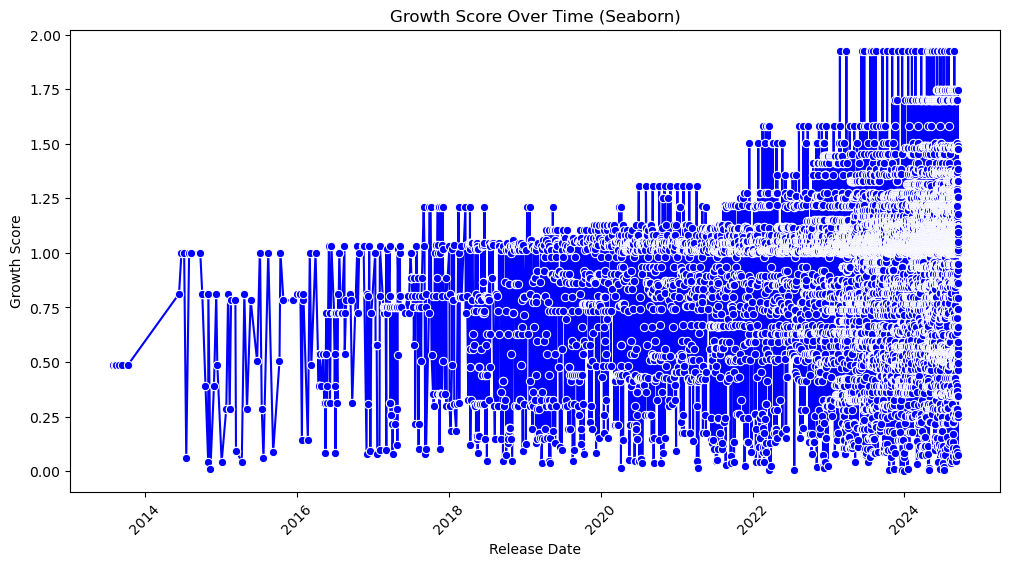

In [43]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x=df_cleaned.index, y=df_cleaned['growth_score'], marker='o', color='b')
plt.title('Growth Score Over Time (Seaborn)')
plt.xlabel('Release Date')
plt.ylabel('Growth Score')
plt.xticks(rotation=45)
plt.show()

In [44]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
result = adfuller(df_cleaned['growth_score'].dropna())

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -8.107098486297406
p-value: 1.2543181647044707e-12


The data is stationary:
-  the ADF statistic of -8.96 is quite negative, which strongly suggests that your time series data is stationary.
- Since the p-value is much lower than the usual significance level of 0.05, we can reject the null hypothesis that the data is non-stationary. This confirms that your data is stationary.

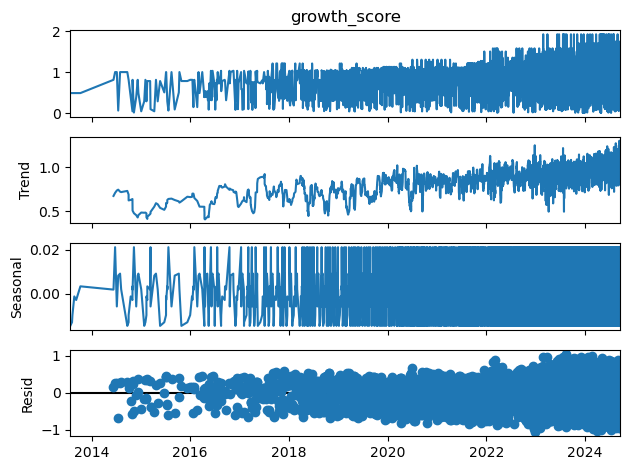

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(df_cleaned['growth_score'], model='additive', period=12)

# Plot the decomposed components
decomposition.plot()
plt.show()

In [46]:
print(release_counts.describe()) 

                     count  mean  std   min   25%   50%   75%   max
repo_name                                                          
AElf                  30.0  30.0  0.0  30.0  30.0  30.0  30.0  30.0
AGiXT                 30.0  30.0  0.0  30.0  30.0  30.0  30.0  30.0
AI                     2.0   2.0  0.0   2.0   2.0   2.0   2.0   2.0
AI-Blocks             11.0  11.0  0.0  11.0  11.0  11.0  11.0  11.0
AI-Lossless-Zoomer     2.0   2.0  0.0   2.0   2.0   2.0   2.0   2.0
...                    ...   ...  ...   ...   ...   ...   ...   ...
yomo                  30.0  30.0  0.0  30.0  30.0  30.0  30.0  30.0
yudao-cloud           14.0  14.0  0.0  14.0  14.0  14.0  14.0  14.0
yudao-ui-admin-vue3   11.0  11.0  0.0  11.0  11.0  11.0  11.0  11.0
zenml                 30.0  30.0  0.0  30.0  30.0  30.0  30.0  30.0
zep                   30.0  30.0  0.0  30.0  30.0  30.0  30.0  30.0

[578 rows x 8 columns]


In [47]:
# Since 25% of repositories have 5 releases or fewer, I'll create 4 lag features. Otherwise a higher number will lead to lots of NaN values.

df_cleaned_with_lag = add_lag_features_based_on_target(df_cleaned)

df_cleaned_with_lag.head()

,org_name,repo_name,num_releases,num_stars,num_forks,num_open_issues,num_pull_requests,growth_score,0,1,...,380,381,382,383,repo_age_days,days_since_last_release,growth_score_lag_1,growth_score_lag_2,growth_score_lag_3,growth_score_lag_4
release_date,,,,,,,,,,,,,,,,,,,,,
2013-09-09 14:19:37+00:00,vim-airline,vim-airline,11,17747,1103,44,853,0.487597,0.041241,-0.050747,...,0.009842,0.005516,0.054387,0.027533,4100,4029,0.487597,0.487597,0.487597,0.487597
2013-10-10 17:59:55+00:00,vim-airline,vim-airline,11,17747,1103,44,853,0.487597,0.041241,-0.050747,...,0.009842,0.005516,0.054387,0.027533,4100,3998,0.487597,0.487597,0.487597,0.487597
2014-06-12 15:29:59+00:00,aio-libs,aiopg,24,1391,159,76,697,0.812224,-0.040947,-0.042826,...,0.043373,-0.011810,0.087497,-0.039265,3823,3753,0.487597,0.487597,0.487597,0.487597
2014-06-24 10:12:06+00:00,aio-libs-abandoned,aioredis-py,29,2298,336,95,1041,1.001357,-0.051876,-0.103019,...,0.009335,0.051719,0.054389,0.041278,3771,3741,0.812224,0.487597,0.487597,0.487597
2014-07-07 08:16:11+00:00,aio-libs-abandoned,aioredis-py,29,2298,336,95,1041,1.001357,-0.051876,-0.103019,...,0.009335,0.051719,0.054389,0.041278,3771,3728,1.001357,0.812224,0.487597,0.487597


In [48]:
# Remove no-longer needed features
df_cleaned_with_lag = df_cleaned_with_lag.drop(columns=['org_name', 'repo_name'])

df_cleaned_with_lag.head()

,num_releases,num_stars,num_forks,num_open_issues,num_pull_requests,growth_score,0,1,2,3,...,380,381,382,383,repo_age_days,days_since_last_release,growth_score_lag_1,growth_score_lag_2,growth_score_lag_3,growth_score_lag_4
release_date,,,,,,,,,,,,,,,,,,,,,
2013-09-09 14:19:37+00:00,11,17747,1103,44,853,0.487597,0.041241,-0.050747,-0.080221,-0.007640,...,0.009842,0.005516,0.054387,0.027533,4100,4029,0.487597,0.487597,0.487597,0.487597
2013-10-10 17:59:55+00:00,11,17747,1103,44,853,0.487597,0.041241,-0.050747,-0.080221,-0.007640,...,0.009842,0.005516,0.054387,0.027533,4100,3998,0.487597,0.487597,0.487597,0.487597
2014-06-12 15:29:59+00:00,24,1391,159,76,697,0.812224,-0.040947,-0.042826,-0.129569,0.090971,...,0.043373,-0.011810,0.087497,-0.039265,3823,3753,0.487597,0.487597,0.487597,0.487597
2014-06-24 10:12:06+00:00,29,2298,336,95,1041,1.001357,-0.051876,-0.103019,-0.099194,0.007320,...,0.009335,0.051719,0.054389,0.041278,3771,3741,0.812224,0.487597,0.487597,0.487597
2014-07-07 08:16:11+00:00,29,2298,336,95,1041,1.001357,-0.051876,-0.103019,-0.099194,0.007320,...,0.009335,0.051719,0.054389,0.041278,3771,3728,1.001357,0.812224,0.487597,0.487597


In [49]:
# Re-transforming the target variable after performing residual analysis after model training and prediction
df_cleaned_with_lag['growth_score'] = np.log1p(df_cleaned_with_lag['growth_score'])
# df_cleaned_with_lag['growth_score'] = np.sqrt(df_cleaned_with_lag['growth_score'])

In [50]:
# Define the features and target
X = df_cleaned_with_lag.drop(columns=['growth_score']).values
y = df_cleaned_with_lag['growth_score'].values


In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [52]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import joblib

# Initialize the scaler
scaler_X = MinMaxScaler()

# Fit the scaler only on the training data
X_train_scaled = scaler_X.fit_transform(X_train)

joblib.dump(scaler_X, '../models/final_input_scaler.pkl')

# Apply the same scaler to the test data
X_test_scaled = scaler_X.transform(X_test)

# If you want to scale y as well, do it the same way
scaler_y = MinMaxScaler()

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

joblib.dump(scaler_y, '../models/final_target_scaler.pkl')

print(X_train_scaled.shape)

(8283, 395)


In [53]:
# X_train_scaled, X_test_scaled = scale_final_data(X_train=X_train, X_test=X_test)

Explained variance ratio by PCA: 0.95


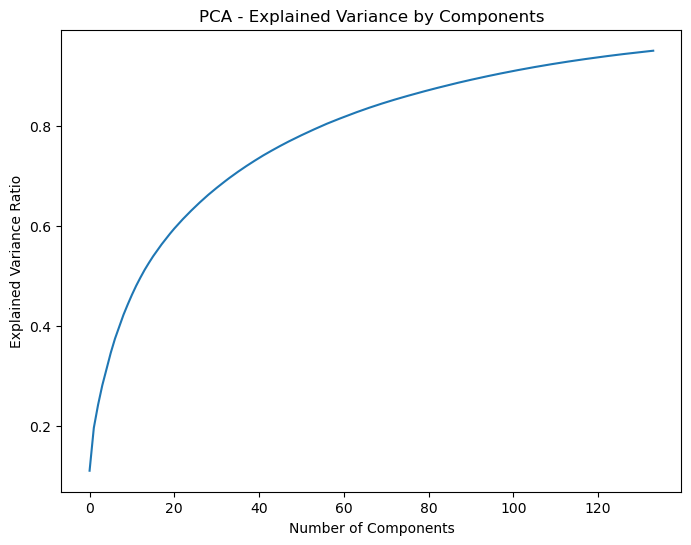

(8283, 134)


In [54]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Set the number of components to retain (e.g., 95% of variance)
pca = PCA(n_components=0.95)

# Fit PCA on training data and transform both train and test sets
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)
joblib.dump(pca, '../models/pca_model.pkl')

print(f'Explained variance ratio by PCA: {np.sum(pca.explained_variance_ratio_):.2f}')

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA - Explained Variance by Components')
plt.show()

print(X_train_scaled_pca.shape)

In [55]:
n_timesteps = 5
n_features_pca = X_train_scaled_pca.shape[1]

In [56]:
# X_train_lstm, y_train_lstm = reshape_for_lstm(X_train_scaled, y_train, n_timesteps)

In [57]:
# X_test_lstm, y_test_lstm = reshape_for_lstm(X_test_scaled, y_test, n_timesteps)

In [58]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

train_generator = TimeseriesGenerator(X_train_scaled_pca, y_train_scaled, length=n_timesteps, batch_size=32)
test_generator = TimeseriesGenerator(X_test_scaled_pca, y_test_scaled, length=n_timesteps, batch_size=32)

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_lstm_model(input_shape, learning_rate=1e-4, lstm_units=128, dropout_rate=0.5):
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(units=lstm_units, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    
    # Output layer (Dense layer with 1 unit for regression task)
    model.add(Dense(1))

    # Compile the model with Adam optimizer and a custom learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [60]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build the LSTM model

input_shape = (n_timesteps, n_features_pca)

model = create_lstm_model(input_shape=input_shape, learning_rate=1e-5, lstm_units=80, dropout_rate=0.2)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../models/best_rnn_model.keras', save_best_only=True, monitor='val_loss')


history = model.fit(train_generator, epochs=100, batch_size=32, validation_data=test_generator, callbacks=[early_stopping, model_checkpoint])

input_shape


Epoch 1/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3861 - val_loss: 0.3606
Epoch 2/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3522 - val_loss: 0.3289
Epoch 3/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3224 - val_loss: 0.2981
Epoch 4/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2928 - val_loss: 0.2673
Epoch 5/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2588 - val_loss: 0.2362
Epoch 6/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2303 - val_loss: 0.2046
Epoch 7/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1974 - val_loss: 0.1729
Epoch 8/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1683 - val_loss: 0.1417
Epoch 9/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1346 - val_loss: 0.1127
Epoch 10/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1073 - val_loss: 0.0872
Epoch 11/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0859 - val_loss: 0.0672
Epoch 12/100
259/259 ━━━━━━━━━━━━━━━━━━━━

(5, 134)

In [61]:
from tensorflow.keras.models import load_model

model = load_model('../models/best_rnn_model.keras')

In [62]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 80)             │        68,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,645 (807.21 KB)

 Trainable params: 68,881 (269.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 137,764 (538.14 KB)

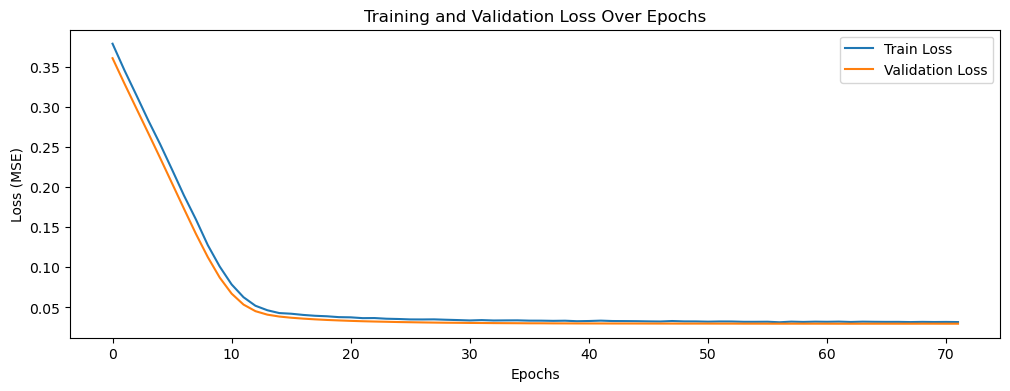

In [63]:
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [64]:
test_loss = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 0.0294
Test Loss: 0.029677651822566986


In [65]:
scaler_y = joblib.load('../models/final_target_scaler.pkl')

# Predict scaled values
y_pred_scaled = model.predict(test_generator)

# y_pred_scaled_reshaped = y_pred_scaled.reshape(-1, 1)

# Inverse transform the predicted values back to the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Initialize a list for the actual values
y_actual = []

# Extract actual values from test_generator
for i in range(len(test_generator)):
    _, target = test_generator[i]  # target is the true y values for the batch
    y_actual.append(target)

# Flatten the array to match y_pred
y_actual = np.concatenate(y_actual).reshape(-1)  

# Flatten the predicted values
y_pred = y_pred.reshape(-1)

# Print one pair of actual vs predicted for verification
print(f'actual: {y_actual[2]}', f' | predicted: {y_pred[2]}')



65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
actual: 0.7310790186239513  | predicted: 0.6497876048088074


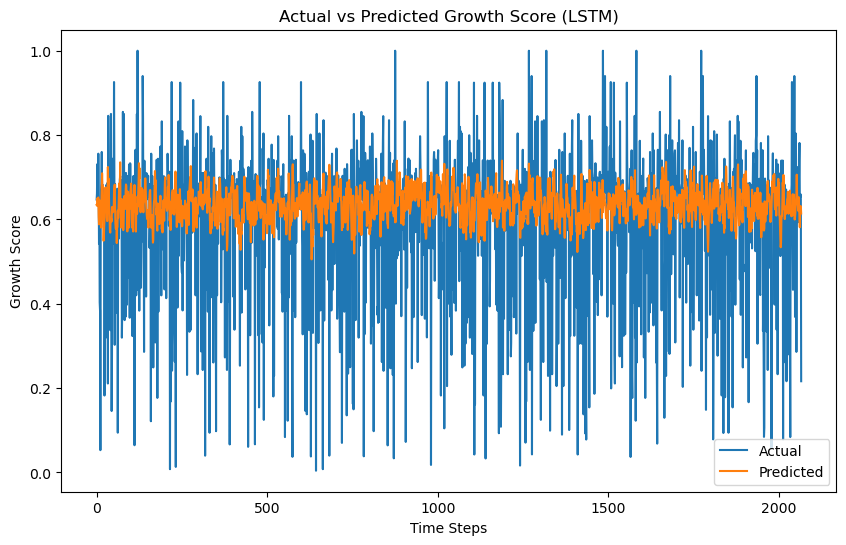

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(y_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Growth Score')
plt.title('Actual vs Predicted Growth Score (LSTM)')
plt.legend()

plt.show()

Considering the model is overpredicting. For this reason it would be important to conduct a residual analysis to better understand the cause of this overprediction.

In [67]:
residuals = y_actual - y_pred
print(residuals)

[ 0.01255521  0.02932389  0.08129141 ...  0.02836249  0.01655334
 -0.39779891]


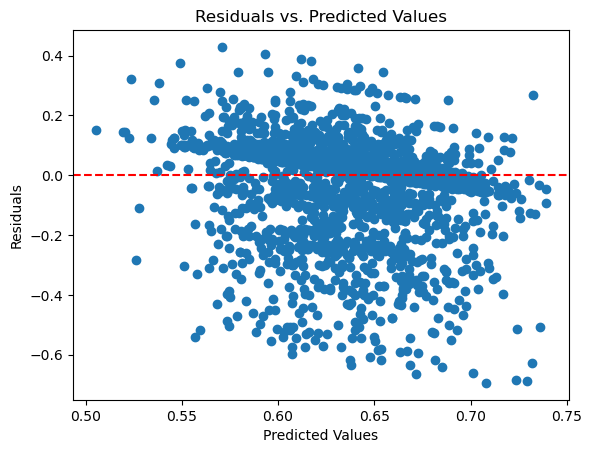

In [68]:
import matplotlib.pyplot as plt

# Residuals vs. predicted values
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

Most of the points are below 0 indicating that the model is not a good fit, suggesting that there's a systematic error in the data.
There is a slight downward trend in the residuals, indicating that the errors are not randomly distributed around 0. This could suggest that there is some non-linearity in the relationship between the input and the target. 

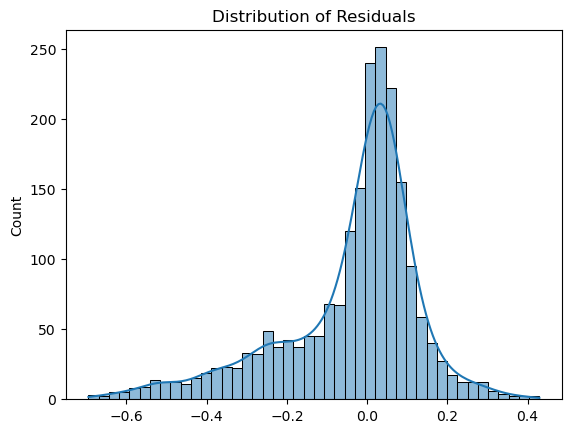

In [69]:
import seaborn as sns

# Histogram of residuals
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

If residuals follow a bell-shaped curve centered around zero, the model’s errors are likely normally distributed.

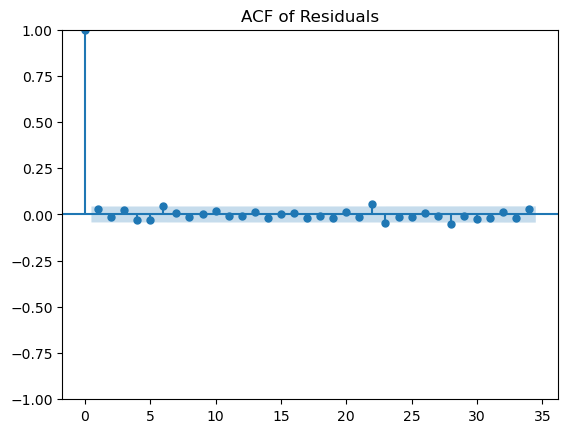

In [70]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelation of residuals
plot_acf(residuals)
plt.title('ACF of Residuals')
plt.show()

If the ACF plot shows significant spikes, it means the residuals are autocorrelated, suggesting the model is missing important temporal patterns.

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')

MSE: 0.03134873516472266
MAE: 0.12094741088724563


In [72]:
n_forecast_steps = 12  # Number of steps to forecast
scaler_y = joblib.load('../models/final_target_scaler.pkl')

# Perform the forecasting
forecasted_values =  forecast_growth(
    model=model, 
    initial_data=X_test_scaled_pca, 
    n_steps=n_forecast_steps, 
    scaler=scaler_y, 
    timesteps=5,
    n_features=n_features_pca
)

print("Forecasted Growth Scores:", forecasted_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Forecasted Growth Scores: [0.62766683 0.6495185  0.647155   0.6026181  0.6242287  0.60477084
 0.60441065 0.6036935  0.6030448  0.60302037 0.60270816 0.6026757 ]


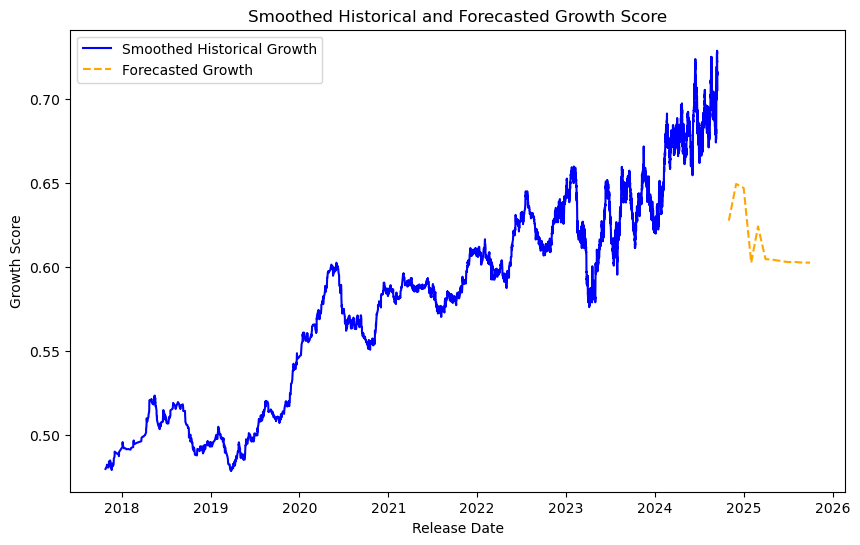

In [73]:
# Ensure the index is in datetime format (if not already)
df_cleaned_with_lag.index = pd.to_datetime(df_cleaned_with_lag.index)

# Historical data: Plot the actual release dates with the growth score
historical_growth = df_cleaned_with_lag['growth_score']

# Generate future dates for the forecasted values based on the release_date index
# If you are forecasting 'n_steps' into the future (assuming monthly intervals)
forecasted_dates = pd.date_range(start=df_cleaned_with_lag.index[-1], periods=n_forecast_steps + 1, freq='M')[1:]


# Apply a rolling average to smooth historical data (using a window of 10)
df_cleaned_with_lag['smoothed_growth_score'] = df_cleaned_with_lag['growth_score'].rolling(window=200).mean()


# Plot the smoothed historical growth score and forecasted data
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned_with_lag.index, df_cleaned_with_lag['smoothed_growth_score'], color='blue', label='Smoothed Historical Growth')
plt.plot(forecasted_dates, forecasted_values, color='orange', linestyle='--', label='Forecasted Growth')

plt.xlabel('Release Date')
plt.ylabel('Growth Score')
plt.title('Smoothed Historical and Forecasted Growth Score')
plt.legend()
plt.show()